In [74]:
from unhippo.models.unhippo import kalman_filter_parameters, regularized_hippo_matrix, discretize_hippo_dynamics, default_dtype, reconstruct_legendre, UnSSMLayer, TimeInvariantUnSSMLayer, unroll_time_invariant_dynamics

In [89]:
l = TimeInvariantUnSSMLayer(32, 200, 1, n_latent_channels=4, trainable=False)
m = unroll_time_invariant_dynamics(data_true[:, None, None], l.A_U, l.K)
yy = l(data_true[:, None, None])

In [96]:
from unhippo.models.krylov import krylov
from unhippo.models.toeplitz import causal_convolution

In [116]:
K = krylov(len(data_true), l.A_U, l.K)
m_cc = causal_convolution(K, data_true, fast=False)

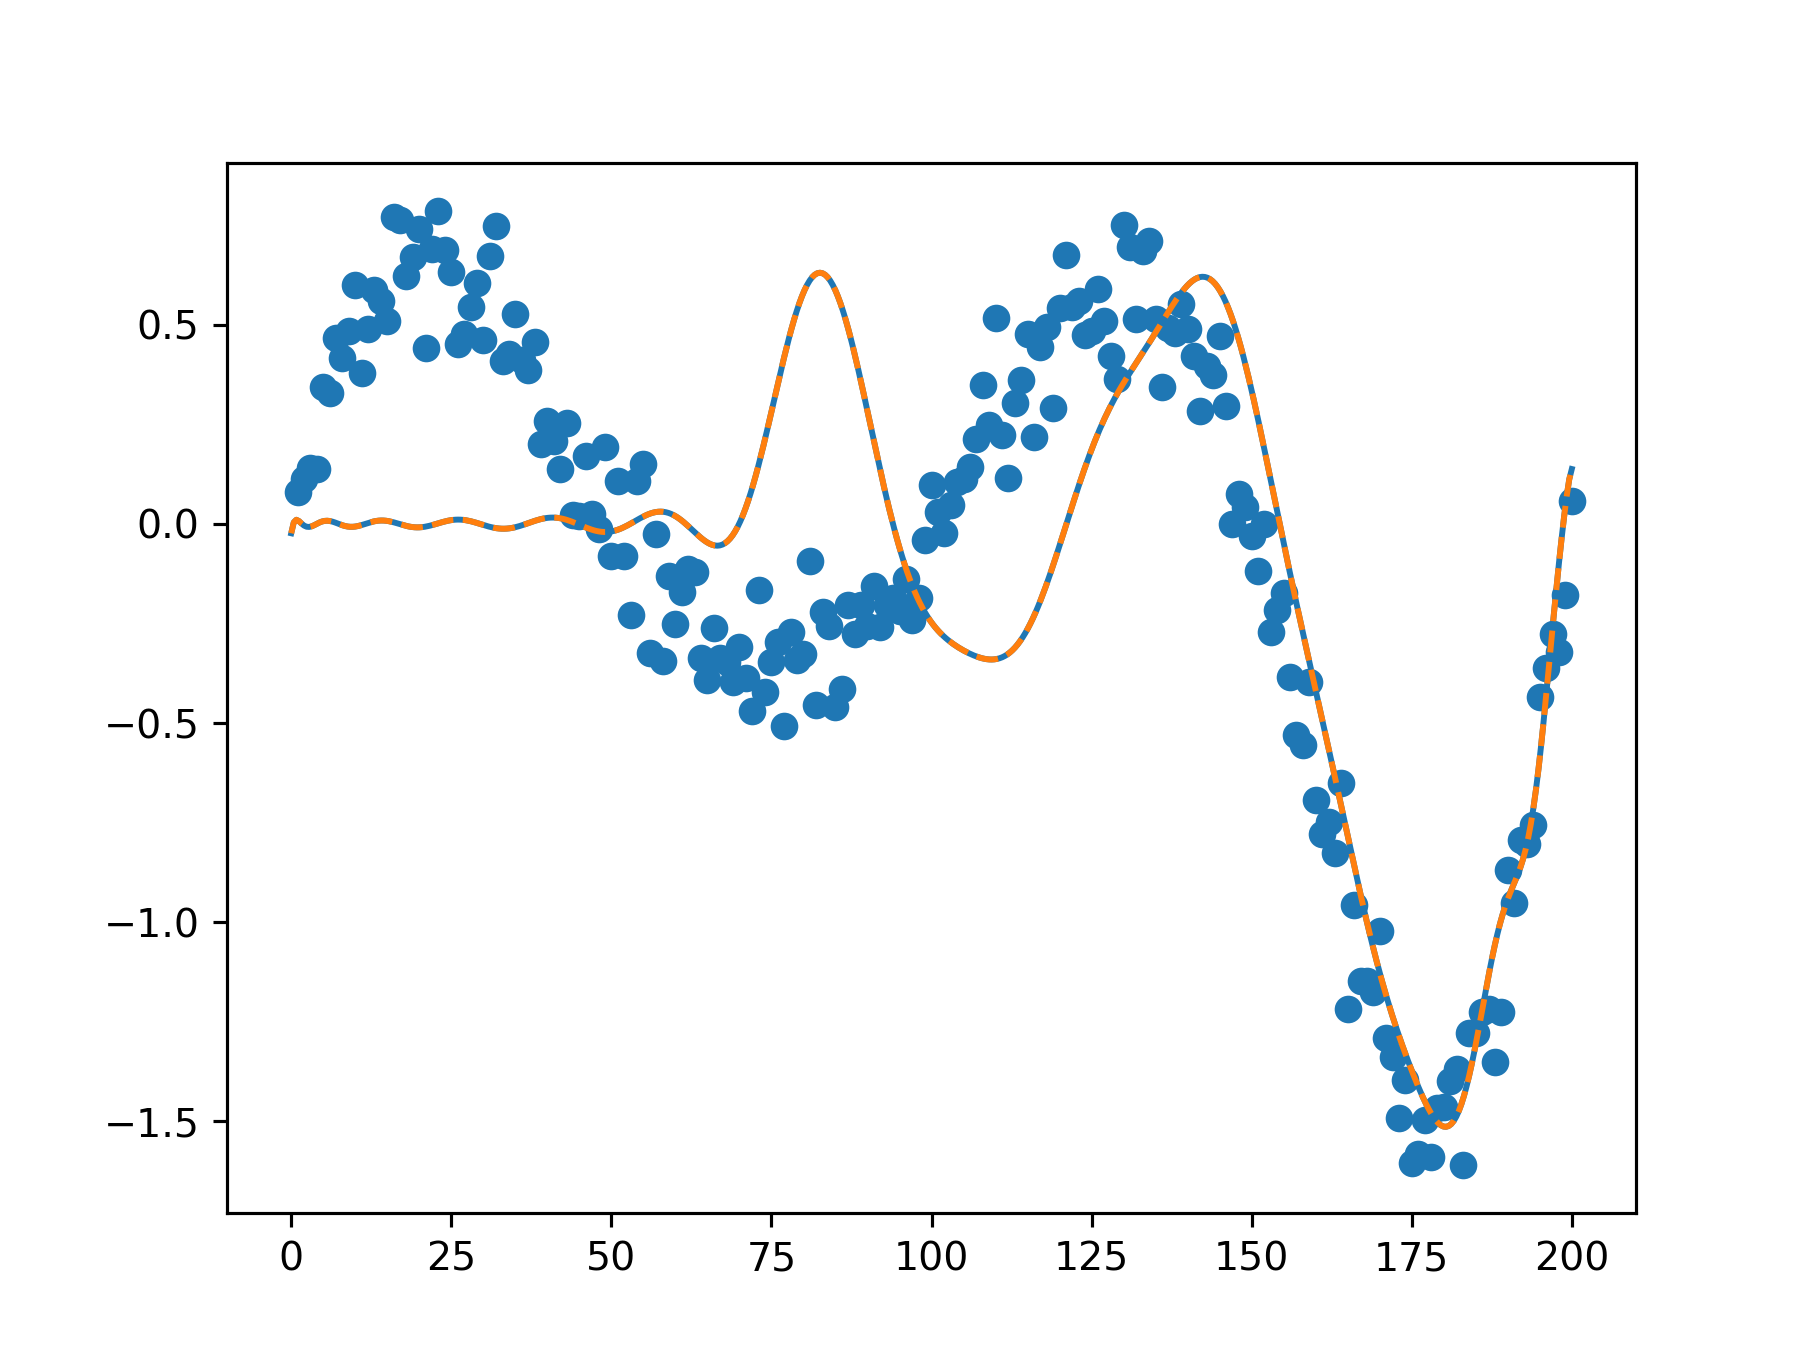

In [112]:
step = 200
t_eval = torch.linspace(0, step, 500)
pp.plot(t_eval, reconstruct_legendre(m[step, 0, 0], domain=(0, step))(t_eval))
pp.plot(t_eval, reconstruct_legendre(m_cc[:, step], domain=(0, step))(t_eval), ls="--")
#pp.plot(yy[:step, 0, 0].numpy(force=True))
pp.scatter(1 + np.arange(step), data_true[:step])

In [2]:
n = 128
steps = 500

In [3]:
def f(t):
    return torch.sin(torch.pi * t) * torch.exp(-torch.sin(t))
rng = np.random.default_rng(1337)
torch.random.manual_seed(1337)
t = ((1 + torch.arange(steps)) / steps) * 10
data_true_ = f(t)
noise = torch.randn(size=(len(t),))
data_true = data_true_ + 0.1 * noise

In [31]:
k = torch.arange(steps + 1)
k[0] = k[1]
A = discretize_hippo_dynamics(regularized_hippo_matrix(n), k[:-1], k[1:], method="expm").float()
B = torch.sqrt(2 * torch.arange(n) + 1)

In [29]:
sigmas = [1e10]#np.logspace(-3, 10, 5)
ms = []

for sigma in sigmas:
    P, K = kalman_filter_parameters(n, steps, A, B, sigma2=sigma, Sigma=torch.eye(n), symmetrize=True, joseph=False)
    
    Id = torch.eye(n)
    A_posterior = (Id - torch.einsum("ki, j -> kij", K, B)) @ A

    m = [torch.zeros(n)]
    for k in range(steps):
        m.append(A_posterior[k] @ m[-1] + K[k] * data_true[k])
    m = torch.stack(m[1:])

    ms.append(m)

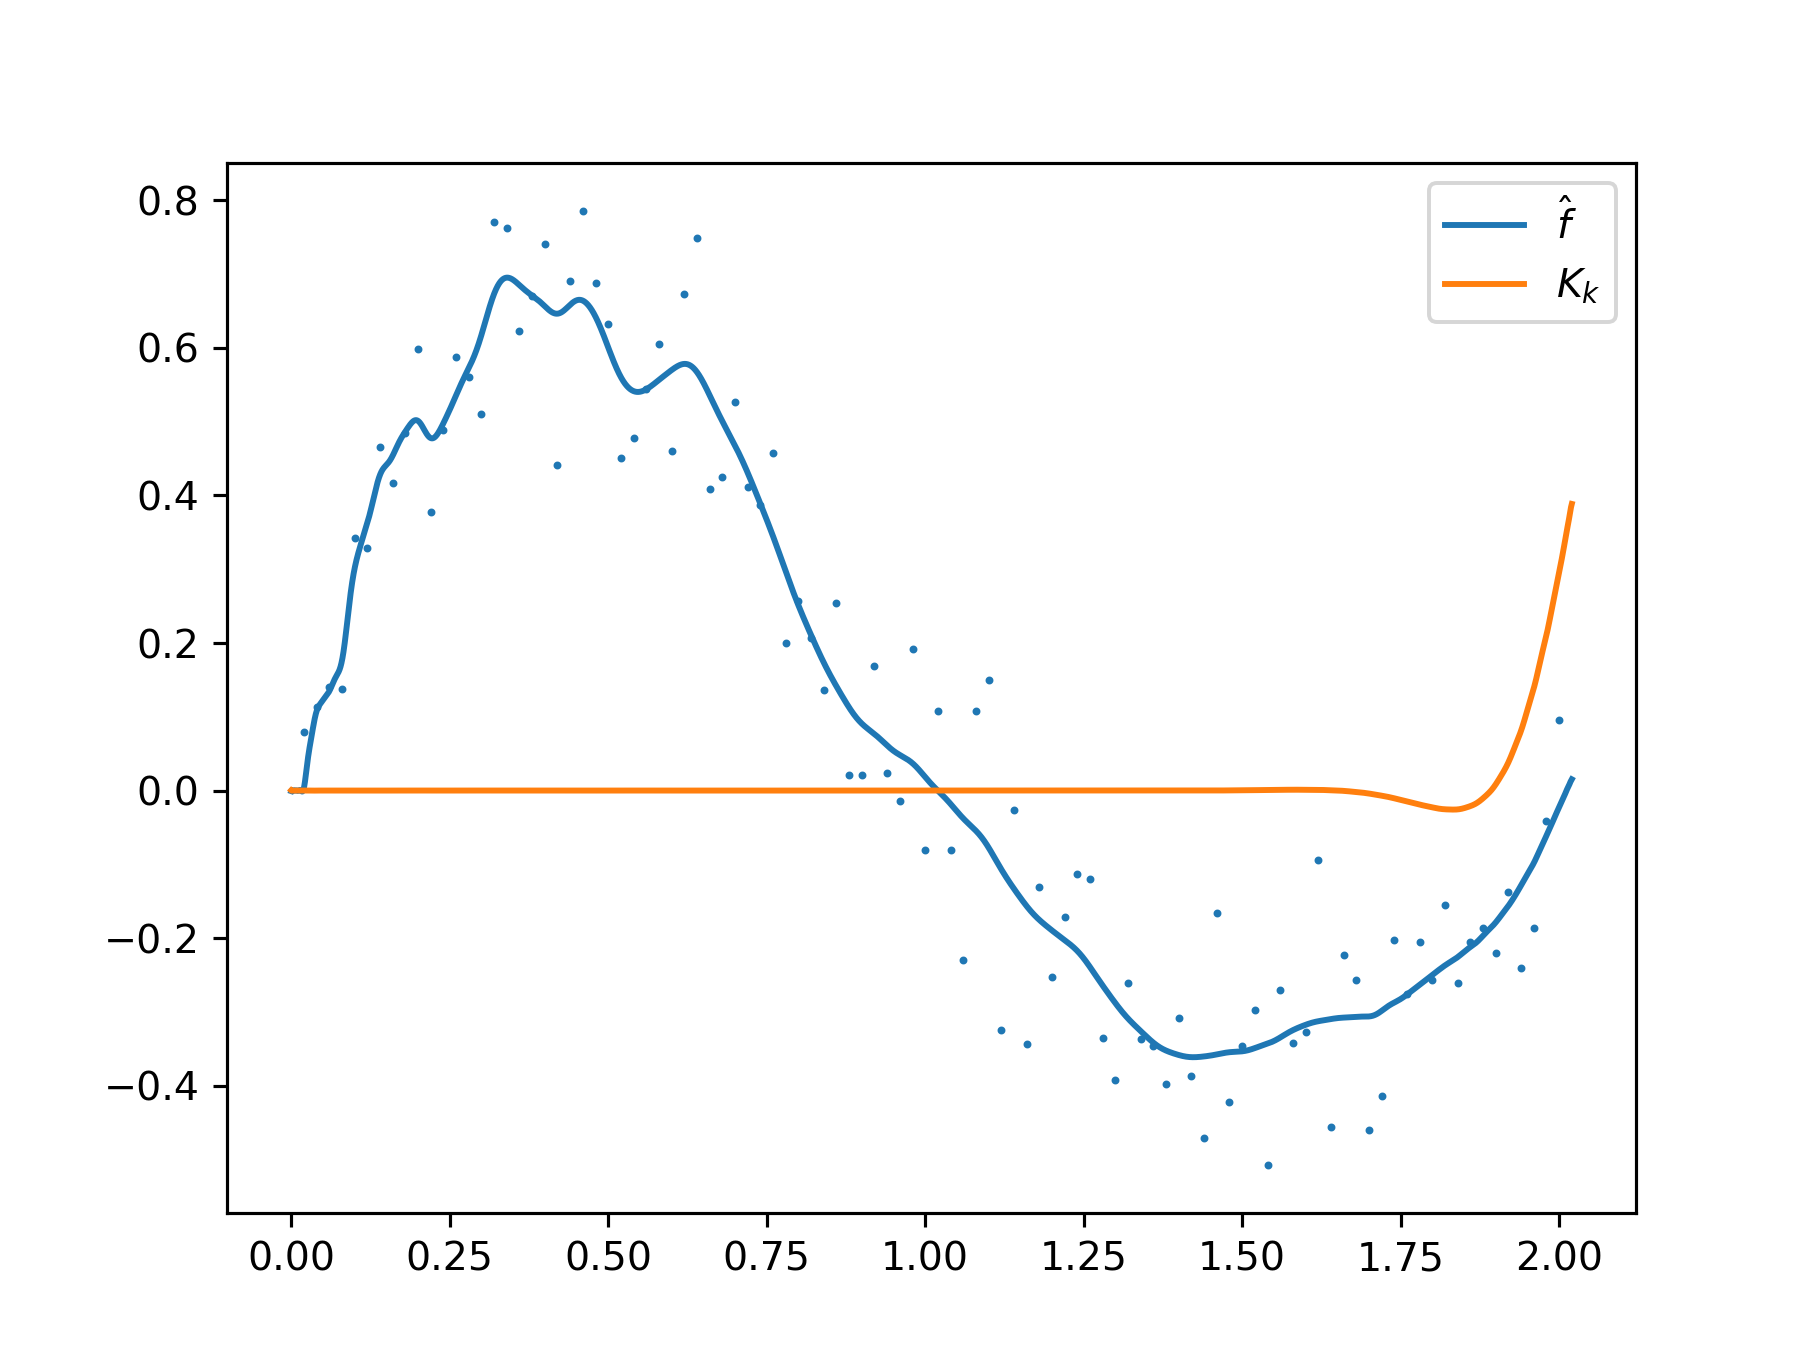

In [30]:
step = 100
t_step = t[:step + 1]
t_eval = np.linspace(0, t_step[-1], 10000)

pp.scatter(t[:step], data_true[:step], s=1.0)
pp.plot(t_eval, reconstruct_legendre(m[step], domain=(t_eval[0], t_eval[-1]))(t_eval), label=r"$\hat{f}$")
pp.plot(t_eval, reconstruct_legendre(K[step], domain=(0, t_step[-1]))(t_eval), label=r"$K_{k}$")

#for sigma, m in zip(sigmas, ms):
    #pp.plot(t_eval, reconstruct_legendre(m[step], domain=(t_eval[0], t_eval[-1]))(t_eval), label=rf"$\sigma = {sigma}$")

pp.legend()

In [67]:
from unhippo.models.krylov import krylov

In [68]:
A = torch.randn((3, 3))
b = torch.randn((5, 3))
L = 7

In [69]:
C = krylov(L, A, b)

In [72]:
C[..., 5]

tensor([[ 122.0130,  -18.0102,   18.4405],
        [-147.6142,   21.2134,  -17.0527],
        [ 191.1754,  -27.4651,   22.1173],
        [-155.0531,   24.1989,  -34.7745],
        [-125.8596,   17.5863,  -10.2491]])

In [73]:
(A @ A @ A @ A @ A @ b[..., None])[..., 0]

tensor([[ 122.0130,  -18.0102,   18.4405],
        [-147.6142,   21.2134,  -17.0527],
        [ 191.1755,  -27.4651,   22.1173],
        [-155.0532,   24.1989,  -34.7745],
        [-125.8596,   17.5863,  -10.2491]])